In [18]:
import torch
from torch import nn
import numpy as np
from torch import distributions
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.nn.functional import pad
import copy

In [19]:
def antiderivTanh(x): # activation function aka the antiderivative of tanh
    return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x)))

def derivTanh(x): # act'' aka the second derivative of the activation function antiderivTanh
    return 1 - torch.pow( torch.tanh(x) , 2 )

class ResNN(nn.Module):
    def __init__(self, m, dx, dy=0, nTh=2):
        """
            ResNet N portion of Phi
        :param d:   int, dimension of space input (expect inputs to be d+1 for space-time)
        :param m:   int, hidden dimension
        :param nTh: int, number of resNet layers , (number of theta layers)
        """
        super().__init__()

        if nTh < 2:
            print("nTh must be an integer >= 2")
            exit(1)

        self.dx = dx
        self.dy = dy
        self.m = m
        self.nTh = nTh
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(dx + dy + 1, m, bias=True)) # opening layer
        self.layers.append(nn.Linear(m,m, bias=True)) # resnet layers
        for i in range(nTh-2):
            self.layers.append(copy.deepcopy(self.layers[1]))
        self.act = antiderivTanh
        self.h = 1.0 / (self.nTh-1) # step size for the ResNet

    def forward(self, x, y=None):
        """
            N(s;theta). the forward propogation of the ResNet
        :param x: tensor nex-by-d+1, inputs
        :return:  tensor nex-by-m,   outputs
        """
        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        xy = self.act(self.layers[0].forward(xy))

        for i in range(1,self.nTh):
            xy = xy + self.h * self.act(self.layers[i](xy))

        return xy



class Phi(nn.Module):
    def __init__(self, nTh, m, dx,dy=0, r=10, alph=[1.0] * 5):
        """
            neural network approximating Phi (see Eq. (9) in our paper)

            Phi( x,t ) = w'*ResNet( [x;t]) + 0.5*[x' t] * A'A * [x;t] + b'*[x;t] + c

        :param nTh:  int, number of resNet layers , (number of theta layers)
        :param m:    int, hidden dimension
        :param d:    int, dimension of space input (expect inputs to be d+1 for space-time)
        :param r:    int, rank r for the A matrix
        :param alph: list, alpha values / weighted multipliers for the optimization problem
        """
        super().__init__()

        self.m    = m
        self.nTh  = nTh
        self.dx = dx
        self.dy = dy
        self.alph = alph

        r = min(r,dx+dy+1) # if number of dimensions is smaller than default r, use that

        self.A  = nn.Parameter(torch.zeros(r, dx + dy+1) , requires_grad=True)
        self.A  = nn.init.xavier_uniform_(self.A)
        self.c  = nn.Linear( dx+dy+1  , 1  , bias=True)  # b'*[x;t] + c
        self.w  = nn.Linear( m    , 1  , bias=False)

        self.N = ResNN(m, dx,dy, nTh=nTh)

        # set initial values
        self.w.weight.data = torch.ones(self.w.weight.data.shape)
        self.c.weight.data = torch.zeros(self.c.weight.data.shape)
        self.c.bias.data   = torch.zeros(self.c.bias.data.shape)



    def forward(self, x, y=None):
        """ calculating Phi(s, theta)...not used in OT-Flow """
        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        # force A to be symmetric
        symA = torch.matmul(torch.t(self.A), self.A) # A'A

        return self.w( self.N(x,y)) + 0.5 * torch.sum( torch.matmul(xy , symA) * xy , dim=1, keepdims=True) + self.c(xy)


    def trHess(self,x,y, justGrad=False ):
        """
        compute gradient of Phi wrt x and trace(Hessian of Phi); see Eq. (11) and Eq. (13), respectively
        recomputes the forward propogation portions of Phi

        :param x: input data, torch Tensor nex-by-d
        :param justGrad: boolean, if True only return gradient, if False return (grad, trHess)
        :return: gradient , trace(hessian)    OR    just gradient
        """

        # code in E = eye(d+1,d) as index slicing instead of matrix multiplication
        # assumes specific N.act as the antiderivative of tanh

        if y is not None:
            xy = torch.cat((x,y),1)
        else:
            xy = x

        N    = self.N
        m    = N.layers[0].weight.shape[0]
        nex  = x.shape[0] # number of examples in the batch
        dx    = x.shape[1]-1
        symA = torch.matmul(self.A.t(), self.A)

        u = [] # hold the u_0,u_1,...,u_M for the forward pass
        z = N.nTh*[None] # hold the z_0,z_1,...,z_M for the backward pass
        # preallocate z because we will store in the backward pass and we want the indices to match the paper

        # Forward of ResNet N and fill u
        opening     = N.layers[0].forward(xy) # K_0 * S + b_0
        u.append(N.act(opening)) # u0
        feat = u[0]

        for i in range(1,N.nTh):
            feat = feat + N.h * N.act(N.layers[i](feat))
            u.append(feat)

        # going to be used more than once
        tanhopen = torch.tanh(opening) # act'( K_0 * S + b_0 )

        # compute gradient and fill z
        for i in range(N.nTh-1,0,-1): # work backwards, placing z_i in appropriate spot
            if i == N.nTh-1:
                term = self.w.weight.t()
            else:
                term = z[i+1]

            # z_i = z_{i+1} + h K_i' diag(...) z_{i+1}
            z[i] = term + N.h * torch.mm( N.layers[i].weight.t() , torch.tanh( N.layers[i].forward(u[i-1]) ).t() * term)

        # z_0 = K_0' diag(...) z_1
        z[0] = torch.mm( N.layers[0].weight.t() , tanhopen.t() * z[1] )
        grad = z[0] + torch.mm(symA, xy.t() ) + self.c.weight.t()

        if justGrad:
            return grad.t()

        # -----------------
        # trace of Hessian
        #-----------------

        # t_0, the trace of the opening layer
        Kopen = N.layers[0].weight[:,0:dx]    # indexed version of Kopen = torch.mm( N.layers[0].weight, E  )
        temp  = derivTanh(opening.t()) * z[1]
        trH  = torch.sum(temp.reshape(m, -1, nex) * torch.pow(Kopen.unsqueeze(2), 2), dim=(0, 1)) # trH = t_0

        # grad_s u_0 ^ T
        temp = tanhopen.t()   # act'( K_0 * S + b_0 )
        Jac  = Kopen.unsqueeze(2) * temp.unsqueeze(1) # K_0' * act'( K_0 * S + b_0 )
        # Jac is shape m by d by nex

        # t_i, trace of the resNet layers
        # KJ is the K_i^T * grad_s u_{i-1}^T
        for i in range(1,N.nTh):
            KJ  = torch.mm(N.layers[i].weight , Jac.reshape(m,-1) )
            KJ  = KJ.reshape(m,-1,nex)
            if i == N.nTh-1:
                term = self.w.weight.t()
            else:
                term = z[i+1]

            temp = N.layers[i].forward(u[i-1]).t() # (K_i * u_{i-1} + b_i)
            t_i = torch.sum(  ( derivTanh(temp) * term ).reshape(m,-1,nex)  *  torch.pow(KJ,2) ,  dim=(0, 1) )
            trH  = trH + N.h * t_i  # add t_i to the accumulate trace
            Jac = Jac + N.h * torch.tanh(temp).reshape(m, -1, nex) * KJ # update Jacobian

        return grad.t(), trH + torch.trace(symA[0:dx,0:dx])
        # indexed version of: return grad.t() ,  trH + torch.trace( torch.mm( E.t() , torch.mm(  symA , E) ) )


In [20]:

def vec(x):
    """vectorize torch tensor x"""
    return x.view(-1,1)


def OTFlowProblem(x, y, Phi, tspan, nt, stepper="rk4", alph=[1.0, 1.0, 1.0]):
    """

    Evaluate objective function of OT Flow problem; see Eq. (8) in the paper.

    :param x:       input data tensor nex-by-dx
    :param y:       input data tensor nex-by-dy
    :param Phi:     neural network
    :param tspan:   time range to integrate over, ex. [0.0 , 1.0]
    :param nt:      number of time steps
    :param stepper: string "rk1" or "rk4" Runge-Kutta schemes
    :param alph:    list of length 3, the alpha value multipliers
    :return:
        Jc - float, objective function value dot(alph,cs)
        cs - list length 5, the five computed costs
    """
    h = (tspan[1]-tspan[0]) / nt

    # initialize "hidden" vector to propogate with all the additional dimensions for all the ODEs
    z = pad(x, (0, 3, 0, 0), value=0)

    tk = tspan[0]

    if stepper=='rk4':
        for k in range(nt):
            z = stepRK4(odefun, z, y, Phi, alph, tk, tk + h)
            tk += h
    elif stepper=='rk1':
        for k in range(nt):
            z = stepRK1(odefun, z, y, Phi, alph, tk, tk + h)
            tk += h

    # ASSUME all examples are equally weighted
    costL  = torch.mean(z[:,-2])
    costC  = torch.mean(C(z))
    costR  = torch.mean(z[:,-1])

    cs = [costL, costC, costR]

    # return dot(cs, alph)  , cs
    return sum(i[0] * i[1] for i in zip(cs, alph)) , cs


def stepRK4(odefun, z, y, Phi, alph, t0, t1):
    """
        Runge-Kutta 4 integration scheme
    :param odefun: function to apply at every time step
    :param z:      tensor nex-by-d+4, inputs
    :param Phi:    Module, the Phi potential function
    :param alph:   list, the 3 alpha values for the OT-Flow Problem
    :param t0:     float, starting time
    :param t1:     float, end time
    :return: tensor nex-by-d+4, features at time t1
    """

    h = t1 - t0 # step size
    z0 = z

    K = h * odefun(z0, y, t0, Phi, alph=alph)
    z = z0 + (1.0/6.0) * K

    K = h * odefun(z0 + 0.5 * K, y, t0 + (h / 2), Phi, alph=alph)
    z += (2.0/6.0) * K

    K = h * odefun(z0 + 0.5 * K, y, t0 + (h / 2), Phi, alph=alph)
    z += (2.0/6.0) * K

    K = h * odefun(z0 + K, y, t0 + h, Phi, alph=alph)
    z += (1.0/6.0) * K

    return z


def stepRK1(odefun, z, y, Phi, alph, t0, t1):
    """
        Runge-Kutta 1 / Forward Euler integration scheme.  Added for comparison, but we recommend stepRK4.
    :param odefun: function to apply at every time step
    :param z:      tensor nex-by-d+4, inputs
    :param Phi:    Module, the Phi potential function
    :param alph:   list, the 3 alpha values for the mean field game problem
    :param t0:     float, starting time
    :param t1:     float, end time
    :return: tensor nex-by-d+4, features at time t1
    """
    z += (t1 - t0) * odefun(z, y, t0, Phi, alph=alph)
    return z


def integrate(x, y, net, tspan, nt, stepper="rk4", alph=[1.0, 1.0, 1.0], intermediates=False):
    """
        perform the time integration in the d-dimensional space
    :param x:       input data tensor nex-by-dx
    :param y:       input data tensor nex-by-dy
    :param net:     neural network Phi
    :param tspan:   time range to integrate over, ex. [0.0 , 1.0]
    :param nt:      number of time steps
    :param stepper: string "rk1" or "rk4" Runge-Kutta schemes
    :param alph:    list of length 3, the alpha value multipliers
    :param intermediates: bool, True means save all intermediate time points along trajectories
    :return:
        z - tensor nex-by-d+4, features at time t1
        OR zFull - tensor nex-by-d+3-by-nt+1 , trajectories from time t0 to t1 (when intermediates=True)
    """

    h = (tspan[1]-tspan[0]) / nt

    # initialize "hidden" vector to propagate with all the additional dimensions for all the ODEs
    z = pad(x, (0, 3, 0, 0), value=tspan[0])

    tk = tspan[0]

    if intermediates: # save the intermediate values as well
        zFull = torch.zeros(*z.shape, nt + 1, device=x.device,
                            dtype=x.dtype)  # make tensor of size z.shape[0], z.shape[1], nt
        zFull[:,:,0] = z

        if stepper == 'rk4':
            for k in range(nt):
                zFull[:, :, k + 1] = stepRK4(odefun, zFull[:, :, k], y, net, alph, tk, tk + h)
                tk += h
        elif stepper == 'rk1':
            for k in range(nt):
                zFull[:, :, k + 1] = stepRK1(odefun, zFull[:, :, k], y, net, alph, tk, tk + h)
                tk += h

        return zFull

    else:
        if stepper == 'rk4':
            for k in range(nt):
                z = stepRK4(odefun, z, y, net, alph, tk, tk + h)
                tk += h
        elif stepper == 'rk1':
            for k in range(nt):
                z = stepRK1(odefun, z, y, net, alph, tk, tk + h)
                tk += h

        return z

    # return in case of error
    return -1



def C(z):
    """Expected negative log-likelihood; see Eq.(3) in the paper"""
    d = z.shape[1]-3
    l = z[:,d] # log-det

    return -( torch.sum(  -0.5 * torch.log(torch.tensor(2.0)*torch.pi) - torch.pow(z[:,0:d],2) / 2  , 1 , keepdims=True ) + l.unsqueeze(1) )


def odefun(x, y, t, net, alph=[1.0, 1.0, 1.0]):
    """
    neural ODE combining the characteristics and log-determinant (see Eq. (2)), the transport costs (see Eq. (5)), and
    the HJB regularizer (see Eq. (7)).

    d_t  [x ; l ; v ; r] = odefun( [x ; l ; v ; r] , t )

    x - particle position
    l - log determinant
    v - accumulated transport costs (Lagrangian)
    r - accumulates violation of HJB condition along trajectory
    """
    nex, d_extra = x.shape
    d = d_extra - 3

    z = pad(x[:, :d], (0, 1, 0, 0), value=t) # concatenate with the time t

    gradPhi, trH = net.trHess(z, y)

    dx = -(1.0/alph[0]) * gradPhi[:,0:d]
    dl = -(1.0/alph[0]) * trH.unsqueeze(1)
    dv = 0.5 * torch.sum(torch.pow(dx, 2) , 1 ,keepdims=True)
    dr = torch.abs(-gradPhi[:, d].unsqueeze(1) + alph[0] * dv)

    return torch.cat( (dx,dl,dv,dr) , 1  )

In [21]:
def calc_next_point(points, angles):
    alpha = angles
    # beta = torch.maximum(torch.pi / 2 - torch.abs(alpha), torch.tensor(0))
    beta = torch.pi / 2 - torch.abs(alpha)
    x = torch.sin(beta) + points[:, 0]
    y_m = alpha / torch.abs(alpha) * torch.cos(beta) + points[:, 1]
    next_point = torch.vstack((x, y_m)).T
    return next_point


def calc_arm_pos(angles):
    first_point = calc_next_point(torch.tensor([[0, 0]]), angles[:, 0])
    middle_point = calc_next_point(first_point, angles[:, 1])
    last_point = calc_next_point(middle_point, angles[:, 2])
    return torch.cat(
        (
            torch.tensor([[[0, 0]]] * len(angles)),
            first_point.unsqueeze(1),
            middle_point.unsqueeze(1),
            last_point.unsqueeze(1),
        ),
        dim=1,
    )


def calc_y(angles):
    return calc_arm_pos(angles)[:, -1]


def data_generator(n):
    scaling_factor = 1
    angles = (
        torch.distributions.uniform.Uniform(-torch.pi / 2, torch.pi / 2).sample(
            (3 * n,)
        )
        * scaling_factor
    )
    x = angles.reshape(n, 3)

    y = calc_y(x)

    return x, y

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
nTh = 4 # number of layers
width = 64 # width of network
alph = [1.0,10.0,5.0] # alph[0]-> weight for transport costs, alph[1] and alph[2]-> HJB penalties
dimx = 3
dimy = 2

net = Phi(nTh=nTh, m=width, dx=dimx, dy=dimy, alph=alph)

prior = distributions.MultivariateNormal(torch.zeros(3).to(device), torch.eye(3).to(device))
nt = 2
x, y = data_generator(1000)

In [24]:
batch_size = 5000
num_steps = 5000

loss_arr = []

optim = torch.optim.Adam(net.parameters(), lr=1e-2) # lr=0.04 good

dataloader = torch.utils.data.DataLoader(list(zip(x,y)), batch_size=batch_size, shuffle=True)
sheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.5)
for step in range(num_steps):
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        Jc, cs = OTFlowProblem(x_batch, y_batch, net, [0.0, 1.0], nt, alph=alph)
        optim.zero_grad()
        Jc.backward()
        optim.step()
        sheduler.step()
        loss_arr.append(Jc.item())
    if step % 200 == 0:
        print(f"Step {step}, Jc: {Jc}, cs: {cs}")

Step 0, Jc: 548.6187133789062, cs: [tensor(64.5782, grad_fn=<MeanBackward0>), tensor(17.1068, grad_fn=<MeanBackward0>), tensor(62.5945, grad_fn=<MeanBackward0>)]
Step 200, Jc: 18.51081085205078, cs: [tensor(0.6891, grad_fn=<MeanBackward0>), tensor(1.5066, grad_fn=<MeanBackward0>), tensor(0.5511, grad_fn=<MeanBackward0>)]
Step 400, Jc: 15.39422607421875, cs: [tensor(0.5651, grad_fn=<MeanBackward0>), tensor(1.2839, grad_fn=<MeanBackward0>), tensor(0.3979, grad_fn=<MeanBackward0>)]
Step 600, Jc: 9.675640106201172, cs: [tensor(0.5187, grad_fn=<MeanBackward0>), tensor(0.7675, grad_fn=<MeanBackward0>), tensor(0.2965, grad_fn=<MeanBackward0>)]
Step 800, Jc: 19.1252498626709, cs: [tensor(1.4662, grad_fn=<MeanBackward0>), tensor(1.3634, grad_fn=<MeanBackward0>), tensor(0.8050, grad_fn=<MeanBackward0>)]
Step 1000, Jc: 7.878868103027344, cs: [tensor(1.1343, grad_fn=<MeanBackward0>), tensor(0.3047, grad_fn=<MeanBackward0>), tensor(0.7395, grad_fn=<MeanBackward0>)]
Step 1200, Jc: -4.285621643066406

KeyboardInterrupt: 

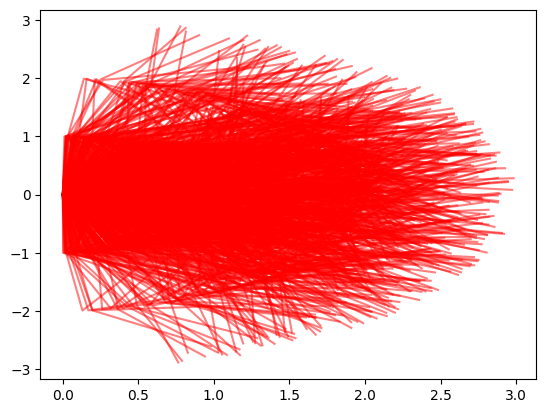

In [25]:
arm_pos = calc_arm_pos(x)
for i in range(arm_pos.shape[0]):
    plt.plot(
        arm_pos[i, :, 0],
        arm_pos[i, :, 1],
        label="Original Data",
        c="red",
        alpha=0.5,
    )

[ 2.5236895  -0.00846899]


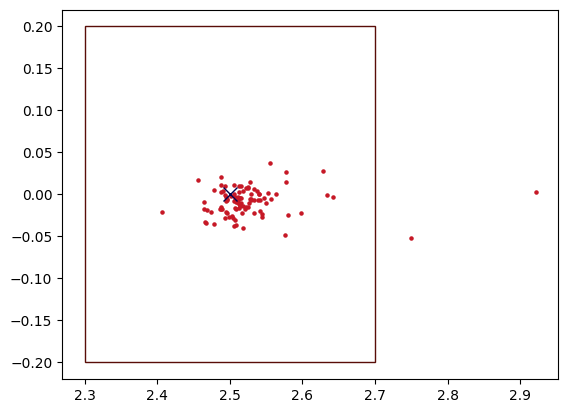

In [26]:
from matplotlib import patches
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'

x_ = 2.5
y_ = 0.0
in_counter = 0
out_counter = 0
tol_area = 0.2
z = prior.sample((100,)).to(device)
cond = torch.tensor([[x_, y_]]).repeat(100, 1).to(device)
finvx = integrate(z, cond, net, [1.0, 0.0], 32, stepper="rk4", alph=net.alph)
modelGen = finvx[:, :dimx].detach().cpu()

y = calc_y(modelGen)
y = y.detach().numpy()
y = y[np.where(y[:, 0] > 0)]
plt.scatter(y[:, 0], y[:, 1], s= 5, color=col_red)
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor=col_dark_red, facecolor='none')
plt.gca().add_patch(rec)

plt.plot(x_, y_, marker='x', markersize=10, color=col_blue)
print(np.mean(y, axis=0))

In [27]:
print(np.mean(y[:, 0]), np.mean(y[:, 1]))

2.52369 -0.008468989


In [28]:
print(np.cov(y[:, 0], y[:, 1]))

[[3.41414875e-03 6.79484663e-05]
 [6.79484663e-05 2.51971181e-04]]


In [29]:
target = [x_, y_]

In [30]:
print(np.mean(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.039840426


In [31]:
print(np.min(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.0024117676


In [32]:
print(np.max(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.4210787


Percentage of points inside the area: 0.95
Percentage of points outside the area: 0.05


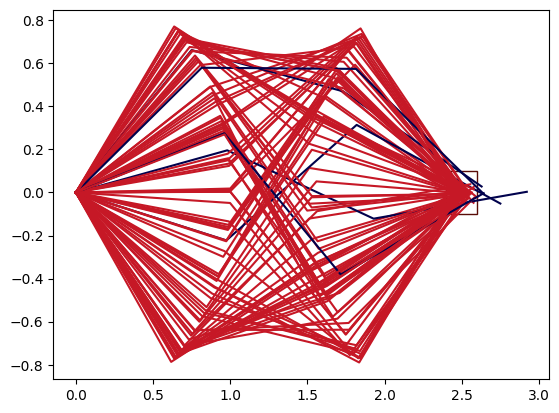

In [33]:
from matplotlib import patches


arm_pos = calc_arm_pos(modelGen)
in_counter = 0
out_counter = 0
tol_area = 0.1

plt.figure()
for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor=col_dark_red, facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / 100}")
print(f"Percentage of points outside the area: {out_counter / 100}")

Percentage of points inside the area: 0.96
Percentage of points outside the area: 0.04


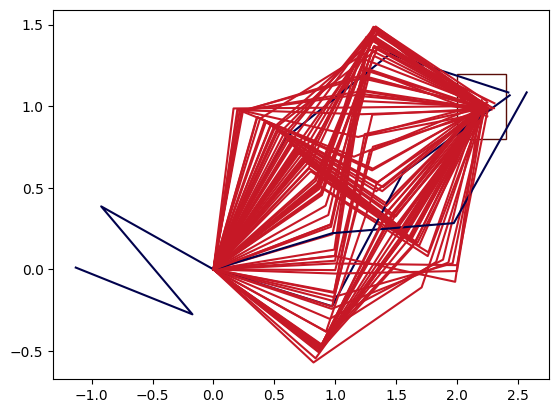

In [34]:
from matplotlib import patches

x_ = 2.2
y_ = 1.0
in_counter = 0
out_counter = 0
tol_area = 0.1
z = prior.sample((100,)).to(device)
cond = torch.tensor([[x_, y_]]).repeat(100, 1).to(device)
finvx = integrate(z, cond, net, [1.0, 0.0], 32, stepper="rk4", alph=net.alph)
modelGen = finvx[:, :dimx].detach().cpu()

y = calc_y(modelGen)
y = y.detach().numpy()
arm_pos = calc_arm_pos(modelGen)
in_counter = 0
out_counter = 0
tol_area = 0.2

plt.figure()
for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor=col_dark_red, facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / 100}")
print(f"Percentage of points outside the area: {out_counter / 100}")